# Sentiment Analysis with Deep Learning using BERT

In [1]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('smile-annotations-final.csv', 
                 names = ['id', 'text', 'category'])
df.set_index('id', inplace=True)

<Axes: ylabel='Frequency'>

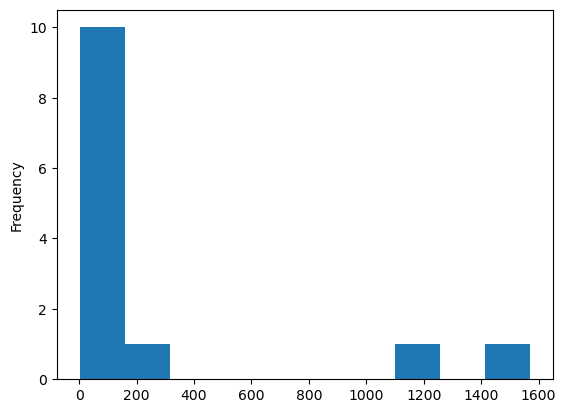

In [3]:
df.category.value_counts().plot(kind='hist')

In [4]:
index_tweet = df[(df['category'] == 'nocode')].index
df.drop(index_tweet, inplace=True)
df = df[~df.category.str.contains('\|')]
df.category.value_counts()

category
happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: count, dtype: int64

In [5]:
label_dict = {
    'happy': 0,
    'not-relevant': 1,
    'angry': 2,
    'surprise': 3,
    'sad': 4,
    'disgust': 5
}

In [6]:
type(label_dict)

dict

In [7]:
df['label'] = df.category.replace(label_dict)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,
    df.label.values,
    test_size = 0.15,
    random_state = 17,
    stratify = df.label.values
)

In [10]:
df['data_type'] = ['not_set']*df.shape[0]

In [11]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [12]:
df.groupby(['category', 'label', 'data_type']).count()

text
category     label data_type      
angry        2     train        48
                   val           9
disgust      5     train         5
                   val           1
happy        0     train       966
                   val         171
not-relevant 1     train       182
                   val          32
sad          4     train        27
                   val           5
surprise     3     train        30
                   val           5

In [13]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [14]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
)

In [15]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt')

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt')

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Varun\anaconda3\envs\llmenv\Lib\site-packages\transformers\tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [17]:
dataset_val[9]

(tensor([  101,  1012,  1030,  2120, 22263,  7301, 26663,  3980,  2006, 12026,
          9883,  2363,  2013,  5806,  1012,  2053, 20096,  1012,  1001,  2396,
         28556, 16770,  1024,  1013,  1013,  1056,  1012,  2522,  1013,  2358,
         27421, 14194,  2487, 16425,  2480,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [18]:
len(dataset_val)

223

In [19]:
from transformers import BertForSequenceClassification

In [20]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = len(label_dict),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [22]:
batch_size = 4
dataloaders_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloaders_val = DataLoader(
    dataset=dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32
)

In [23]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [24]:
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

c:\Users\Varun\anaconda3\envs\llmenv\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
epochs = 10

scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloaders_train)*epochs
)

In [26]:
import numpy as np

In [27]:
from sklearn.metrics import f1_score

In [28]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [29]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat == label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)}')

In [30]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [32]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals


## Freezing Layers for Fine-tuning.

In [33]:
for name, param in model.named_parameters():
    if name.startswith('bert.encoder.layer.0'):
        param.requires_grad = False
    if name.startswith('bert.encoder.layer.1'):
        param.requires_grad = False
    if name.startswith('bert.encoder.layer.2'):
        param.requires_grad = False
    if name.startswith('bert.encoder.layer.3'):
        param.requires_grad = False
    if name.startswith('bert.encoder.layer.4'):
        param.requires_grad = True
    if name.startswith('bert.encoder.layer.5'):
        param.requires_grad = True
    if name.startswith('bert.encoder.layer.6'):
        param.requires_grad = True
    if name.startswith('bert.encoder.layer.7'):
        param.requires_grad = True
    if name.startswith('bert.encoder.layer.8'):
        param.requires_grad = True
    if name.startswith('bert.encoder.layer.9'):
        param.requires_grad = True
    if name.startswith('bert.encoder.layer.10'):
        param.requires_grad = True
    if name.startswith('bert.encoder.layer.11'):
        param.requires_grad = True
    print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.LayerNor

In [34]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    
    loss_train_total = 0
    progress_bar = tqdm(dataloaders_train, desc = 'Epoch {:1d}'.format(epoch),
                       leave = False,
                       disable = False)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    torch.save(model.state_dict(), f'Models/BERT_ft_epoch{epoch}.model')
    
    tqdm.write('\nEpoch{epoch}')
    loss_train_avg = loss_train_total/len(dataloaders_train)
    tqdm.write(f'Training Loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloaders_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation Loss: {val_loss}')
    tqdm.write(f'F1 Score(weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch{epoch}
Training Loss: 0.7688178619340299
Validation Loss: 0.5637298737253461
F1 Score(weighted): 0.7799931010693343


Epoch 2:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch{epoch}
Training Loss: 0.4567030928659415
Validation Loss: 0.5674779628004346
F1 Score(weighted): 0.8175910700228352


Epoch 3:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch{epoch}
Training Loss: 0.3270618980099994
Validation Loss: 0.5491878688335419
F1 Score(weighted): 0.8502763330763634


Epoch 4:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch{epoch}
Training Loss: 0.21910040492214086
Validation Loss: 0.6456359901598522
F1 Score(weighted): 0.8637598262720534


Epoch 5:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch{epoch}
Training Loss: 0.15404614857508844
Validation Loss: 0.6057738895927157
F1 Score(weighted): 0.8723406490146413


Epoch 6:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch{epoch}
Training Loss: 0.09958732379692799
Validation Loss: 0.6959014875548226
F1 Score(weighted): 0.8557832916378623


Epoch 7:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch{epoch}
Training Loss: 0.07024346318683543
Validation Loss: 0.7033327498606273
F1 Score(weighted): 0.8647895245428878


Epoch 8:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch{epoch}
Training Loss: 0.046010625116260986
Validation Loss: 0.6727561141763415
F1 Score(weighted): 0.8704639672476381


Epoch 9:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch{epoch}
Training Loss: 0.03320169370623291
Validation Loss: 0.659348155770983
F1 Score(weighted): 0.8773808910193632


Epoch 10:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch{epoch}
Training Loss: 0.02904746021829649
Validation Loss: 0.6715543035949979
F1 Score(weighted): 0.8692851447546528


In [36]:
model.load_state_dict(torch.load('Models/BERT_ft_epoch10.model',
                                map_location=torch.device(device)))

<All keys matched successfully>

In [37]:
_,predictions, true_vals = evaluate(dataloaders_val)

In [38]:
accuracy_per_class(predictions, true_vals)

Class: happy
Accuracy: 166/171
Class: not-relevant
Accuracy: 18/32
Class: angry
Accuracy: 8/9
Class: surprise
Accuracy: 3/5
Class: sad
Accuracy: 1/5
Class: disgust
Accuracy: 0/1
